**Master en Inteligencia Artificial Aplicada - IA en Finanzas**

# Proyecto 3. *Sentiment Analysis* en Finanzas

### Jose M. Leiva

#### **Autores** : Lucía Cordero y Jorge Garcelán

## Descarga de datos de precios

A continuación descargaremos los precios históricos de un ETF que replica al índice SP500 de las 500 compañías norteamericanas de mayor capitalización. Dicho ETF tiene el ticker SPY. Para descargar los datos, usaremos una API de Yahoo Finance para Python (documentación [aquí](https://pypi.org/project/yfinance/)).

In [1]:
!pip install -q yfinance
import yfinance as yf
import pandas as pd

Descargue las cotizaciones de los últimos 5 años.

In [2]:
data = yf.download("SPY", period="5y")
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2020-03-12,230.028839,247.227000,229.630168,237.343850,392220700
2020-03-13,249.693130,251.695722,230.408942,243.917136,329566100
2020-03-16,222.370804,238.178264,220.062259,223.603867,297240000
2020-03-17,234.377075,237.501494,219.793411,227.182580,262070500
2020-03-18,222.509857,230.269884,211.402911,219.033141,327597100
...,...,...,...,...,...
2025-03-05,583.059998,584.880005,573.080017,576.690002,71230500
2025-03-06,572.710022,580.169983,570.119995,575.479980,80094900


Cambie la frecuencia de la serie temporal a **semanal** tomando los precios de los viernes.

In [3]:
# Primero eliminamos la columna ticker
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)

# Hacemos remuestreo de las fechas a índices semanales tomando el viernes
data = data.resample('W-FRI').ffill()

In [4]:
data

Price,Close,High,Low,Open,Volume
Date,,,,,
2020-03-13,249.693130,251.695722,230.408942,243.917136,329566100
2020-03-20,213.373444,227.986911,213.093668,226.177711,347158800
2020-03-27,236.333450,243.225188,234.123249,236.193570,224341200
2020-04-03,231.456070,236.240190,228.686318,233.852783,135561200
2020-04-10,259.442749,262.240478,256.896805,258.864528,189999200
...,...,...,...,...,...
2025-02-14,609.700012,610.989990,609.070007,609.940002,26910400
2025-02-21,599.940002,610.299988,599.469971,610.159973,76519800
2025-02-28,594.179993,594.719971,582.440002,585.559998,88744100


## Análisis del Sentimiento de mercado con GDELT

Como se ha visto en clase, GDELT es un excelente recurso para medir el tono y la cobertura de las noticias que mencionan una determinada palabra o temática.

GDELT 2.0 dispone de una REST API con la que podemos realizar consultas. Más conveniente aún, existe una librería para hacer uso de esa API desde Python!

[Aquí](https://github.com/alex9smith/gdelt-doc-api) puede consultarse el repo de GdeltDoc.

En este proyecto desarrollaremos **una estrategia basada en la cobertura de los medios a ciertas palabras clave**.


In [5]:
!pip install -q GdeltDoc

Descargue la cobertura que han dado los medios norteamericanos a las noticias que contengan alguna palabra clave relacionada con la economía (por ejemplo, *economics*). Para ello, invoque la función *timeline_search* de la forma:

*gd.timeline_search("timelinevol", f)*

para obtener el porcentaje de artículos que se ajustan a los filtros en *f* a lo largo del tiempo.

In [64]:
from gdeltdoc import GdeltDoc, Filters

# Cobertura de 'economics' de los últimos 5 años
f = Filters(
    keyword = "economics",
    country = "US",
    timespan = "60m",
)

gd = GdeltDoc()

# Realizar la consulta a la API de GDELT
timeline = gd.timeline_search("timelinevol", f)
timeline

,datetime,Volume Intensity
0,2020-04-08 00:00:00+00:00,0.1635
1,2020-04-09 00:00:00+00:00,0.3450
2,2020-04-10 00:00:00+00:00,0.2292
3,2020-04-11 00:00:00+00:00,0.1847
4,2020-04-12 00:00:00+00:00,0.2139
...,...,...
1793,2025-03-08 00:00:00+00:00,0.1036
1794,2025-03-09 00:00:00+00:00,0.1346
1795,2025-03-10 00:00:00+00:00,0.1464
1796,2025-03-11 00:00:00+00:00,0.1629


In [65]:
import matplotlib.pyplot as plt
import pandas as pd

timeline['datetime'] = pd.to_datetime(timeline['datetime'])

# Ordenar los datos de mayor a menor por Volume Intensity
top_dates = timeline.sort_values(by="Volume Intensity", ascending=False)
print("Fechas con mayor cobertura de noticias sobre el economía en los últimos 60 meses:")
print(top_dates.head(3))

Fechas con mayor cobertura de noticias sobre el desempleo en los últimos 60 meses:
                     datetime  Volume Intensity
385 2021-04-29 00:00:00+00:00            0.4580
181 2020-10-06 00:00:00+00:00            0.4167
330 2021-03-05 00:00:00+00:00            0.3455


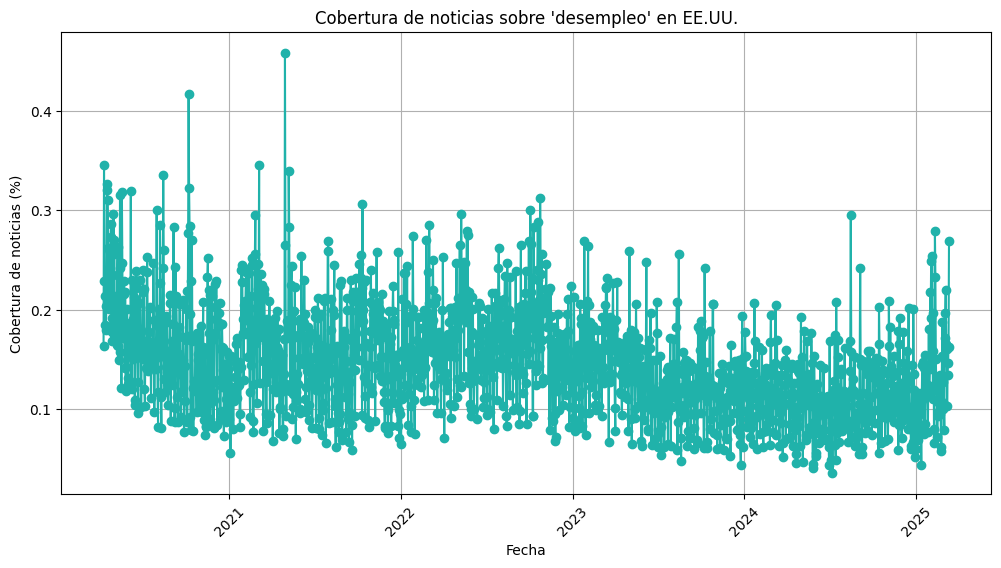

In [66]:
# Crear el gráfico
plt.figure(figsize=(12, 6))
plt.plot(timeline['datetime'], timeline['Volume Intensity'], marker='o', linestyle='-', color='lightseagreen')
plt.xlabel("Fecha")
plt.ylabel("Cobertura de noticias (%)")
plt.title("Cobertura de noticias sobre 'economics' en EE.UU.")
plt.xticks(rotation=45)
plt.grid()
plt.show()

**Respuesta**: Los días con mayor volumen de cobertura en EE.UU. sobre economía corresponden con días de 2021 y 2021, fechas en las que aún estábamos inmersos en la COVID-19 y se especulaba sobre cómo iba a afectar la pandemia a la economía global.

A continuación realice las siguientes acciones:
1. Como queremos tener un indicador semanal en lugar de diario, calcule una media móvil de 7 días (use el método de pandas *rolling('7D')* seguido de *mean()*).
2. Cambie la frecuencia a semanal para alinearla con los datos de precios.
3. Realice un ejercicio de backtesting para evaluar la estrategia de comprar o vender el índice en función de si el volumen de noticias sube o baja cada semana.
4. Repita el ejercicio usando el tono en lugar del volumen. Para ello invoque ahora la función *timeline_search* con la opción "timelinetone".
5. Experimente con distintas palabras clave. ¿Ha encontrado alguna con la que supere el retorno del índice?


#### Ejercicio 1: Calcule una media móvil de 7 días



In [67]:
# Ponemos datetime como índice del dataframe
timeline.set_index('datetime', inplace=True)

# Convertimos el índice de 'timeline' a un formato sin zona horaria
timeline.index = timeline.index.tz_convert(None)

# Calculamos media móvil de 7 días y cambiar la frecuencia a semanal
timeline['rolling_avg'] = timeline['Volume Intensity'].rolling('7D').mean()


#### Ejercicio 2: Cambie la frecuencia a semanal para alinearla con los datos de precios


In [ ]:
# Cambiamos la frecuencia semanal
timeline_weekly = timeline.resample('W-FRI').ffill()

In [68]:
# Datos del volumen de cobertura + datos de precios del SPY
merged_data = data[['Close']].merge(timeline_weekly['rolling_avg'], left_index=True, right_index=True, how='left')

# Rellenamos los missing values con el valor anterior
merged_data = merged_data.fillna(method='ffill')


<ipython-input-68-aa4f3457ae23>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data = merged_data.fillna(method='ffill')


In [72]:
# merged_data

#### Ejercicio 3: Backtesting para evaluar la estrategia de comprar o vender el índice en función de si el volumen de noticias sube o baja cada semana

In [70]:
# Añadir la columna 'buy' basada en la cobertura de noticias con la palabra 'economics'
merged_data['buy'] = merged_data['rolling_avg'].diff() < 0

# Calcular los retornos semanales del índice y la estrategia
merged_data['index_return'] = merged_data['Close'].pct_change()
merged_data['portfolio_return'] = merged_data['index_return'] * merged_data['buy']

# Calcular el retorno acumulado
merged_data['index_return_cum'] = (1 + merged_data['index_return']).cumprod()
merged_data['portfolio_return_cum'] = (1 + merged_data['portfolio_return']).cumprod()

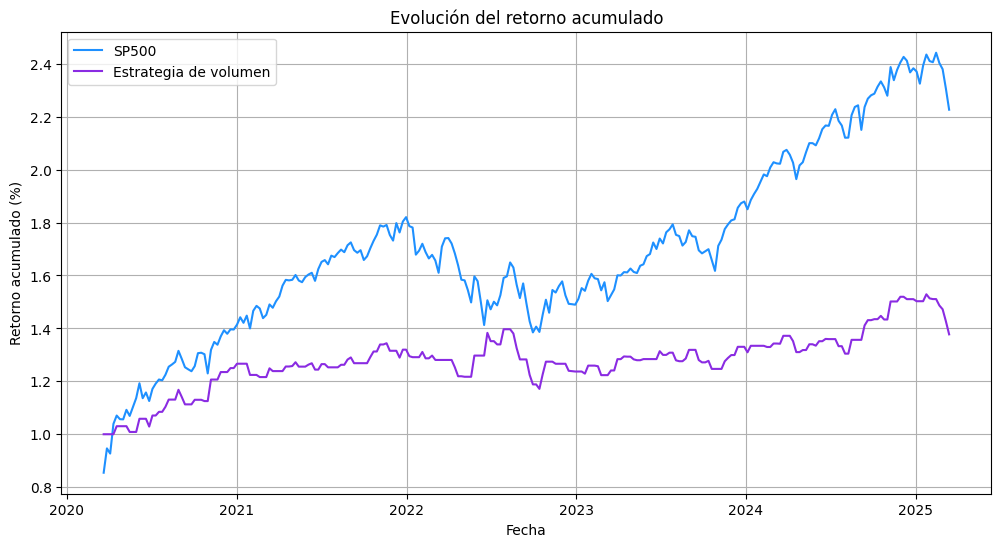

In [78]:
import matplotlib.pyplot as plt

# Gráfico de la evolución del retorno acumulado del índice y de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(merged_data.index, merged_data['index_return_cum'], label='SP500', linestyle='-', color='dodgerblue')
plt.plot(merged_data.index, merged_data['portfolio_return_cum'], label='Estrategia de volumen', linestyle='-', color='blueviolet')
plt.xlabel('Fecha')
plt.ylabel('Retorno acumulado (%)')
plt.title('Evolución del retorno acumulado')
plt.legend()
plt.grid()
plt.show()

**Respuesta**: A partir del gráfico observamos que el rendimiento de la estrategia de comprar o vender el índice en función de si el volumen de noticias sube o baja cada semana es considerablemente peor al rendimiento acumulado del ETF que replica al SP500. La diferencia es especialmente significativa entre 2023 y 2025.

#### Ejercicio 4: Repita el ejercicio usando el tono en lugar del volumen.

In [73]:
# Consulta del tono a la API
timeline = gd.timeline_search("timelinetone", f)
timeline

,datetime,Average Tone
0,2020-04-08 00:00:00+00:00,-1.2878
1,2020-04-09 00:00:00+00:00,-1.8046
2,2020-04-10 00:00:00+00:00,-1.9225
3,2020-04-11 00:00:00+00:00,-2.8563
4,2020-04-12 00:00:00+00:00,-3.0146
...,...,...
1793,2025-03-08 00:00:00+00:00,-1.2609
1794,2025-03-09 00:00:00+00:00,-1.0732
1795,2025-03-10 00:00:00+00:00,-0.3185
1796,2025-03-11 00:00:00+00:00,-1.6526


Ahora veamos cuántos días son positivos y cuántos negativos:

In [74]:
# Contar los días con tono negativo y positivo
dias_neg = (timeline["Average Tone"] < 0).sum()
dias_pos = (timeline["Average Tone"] > 0).sum()

print(f"Días con sentimiento positivo: {dias_pos}")
print(f"Días con sentimiento negativo: {dias_neg}")

Días con tono negativo: 1486
Días con tono positivo: 312


Hay muchos más días con sentimiento negativo que positivo, lo cual es lógico.

In [75]:
# Ponemos datetime como índice del dataframe
timeline.set_index('datetime', inplace=True)

# Convertimos el índice de 'timeline' a un formato sin zona horaria
timeline.index = timeline.index.tz_convert(None)

# Calculamos media móvil de 7 días y cambiar la frecuencia a semanal
timeline['rolling_avg'] = timeline['Average Tone'].rolling('7D').mean()

# Cambiamos la frecuencia semanal
timeline_weekly = timeline.resample('W-FRI').ffill()

# Unimos los datos del tono + datos de precios del SPY
merged_data = data[['Close']].merge(timeline_weekly['rolling_avg'], left_index=True, right_index=True, how='left')

# Rellenamos los missing values con el valor anterior
merged_data = merged_data.fillna(method='ffill')

# Añadir la columna 'buy' basada en la cobertura de noticias con la palabra 'economics'
merged_data['buy'] = merged_data['rolling_avg'].diff() < 0

# Calcular los retornos semanales del índice y la estrategia
merged_data['index_return'] = merged_data['Close'].pct_change()
merged_data['portfolio_return'] = merged_data['index_return'] * merged_data['buy'] # data['buy']=1 (True) | data['buy']=0 (False)

# Calcular el retorno acumulado
merged_data['index_return_cum'] = (1 + merged_data['index_return']).cumprod()
merged_data['portfolio_return_cum'] = (1 + merged_data['portfolio_return']).cumprod()


<ipython-input-75-cdcab62e3d2f>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data = merged_data.fillna(method='ffill')


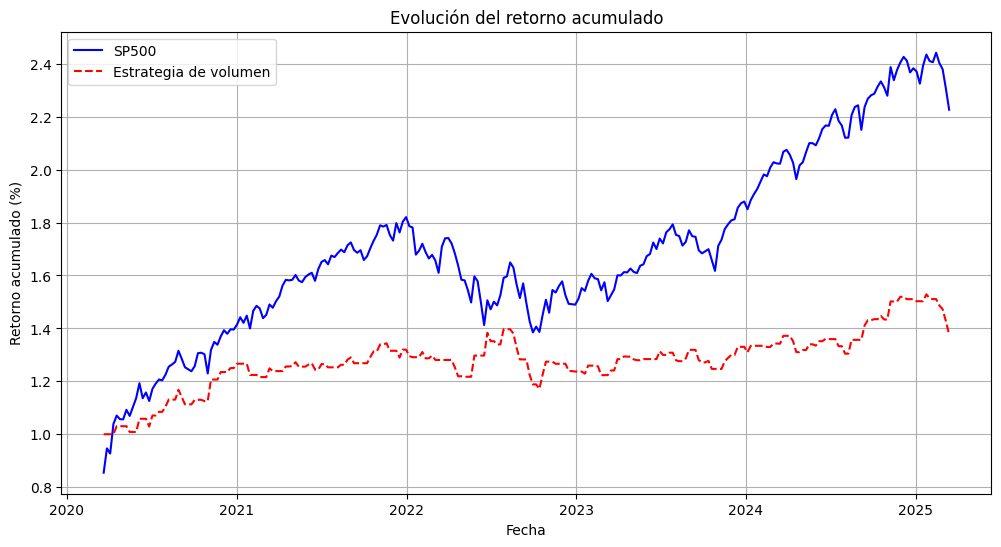

In [76]:
# Gráfico de la evolución del retorno acumulado del índice y de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(merged_data.index, merged_data['index_return_cum'], label='SP500', linestyle='-', color='dodgerblue')
plt.plot(merged_data.index, merged_data['portfolio_return_cum'], label='Estrategia de tono', linestyle='-', color='blueviolet')
plt.xlabel('Fecha')
plt.ylabel('Retorno acumulado (%)')
plt.title('Evolución del retorno acumulado')
plt.legend()
plt.grid()
plt.show()

**Respuesta**: A partir del gráfico observamos que el rendimiento de la estrategia de comprar o vender el índice en función del tono de noticias es algo peor al rendimiento acumulado del ETF que replica al SP500, sin embargo es mejor que el rendimiento acumulado con la estrategia de volumen. Además, nuestra estrategia crece de forma más constante que la del índice, por lo que experimenta menos subidas o declives bruscos (aporta más seguridad porque hay menos riesgos).

#### Ejercicio 5: Experimente con distintas palabras clave. ¿Ha encontrado alguna con la que supere el retorno del índice?

##### Palabra: unemployment

In [79]:
# Cobertura de 'unemployment' de los últimos 5 años
f = Filters(
    keyword = "unemployment",
    country = "US",
    timespan = "60m",
)

gd = GdeltDoc()

# Realizar la consulta a la API de GDELT
timeline = gd.timeline_search("timelinevol", f)
timeline

,datetime,Volume Intensity
0,2020-04-08 00:00:00+00:00,1.0044
1,2020-04-09 00:00:00+00:00,1.8573
2,2020-04-10 00:00:00+00:00,1.6182
3,2020-04-11 00:00:00+00:00,1.0820
4,2020-04-12 00:00:00+00:00,0.7470
...,...,...
1793,2025-03-08 00:00:00+00:00,0.1999
1794,2025-03-09 00:00:00+00:00,0.0895
1795,2025-03-10 00:00:00+00:00,0.1618
1796,2025-03-11 00:00:00+00:00,0.1962


In [80]:
# Ponemos datetime como índice del dataframe
timeline.set_index('datetime', inplace=True)

# Convertimos el índice de 'timeline' a un formato sin zona horaria
timeline.index = timeline.index.tz_convert(None)

# Calculamos media móvil de 7 días y cambiar la frecuencia a semanal
timeline['rolling_avg'] = timeline['Volume Intensity'].rolling('7D').mean()

# Cambiamos la frecuencia semanal
timeline_weekly = timeline.resample('W-FRI').ffill()

# Unimos los datos del tono + datos de precios del SPY
merged_data = data[['Close']].merge(timeline_weekly['rolling_avg'], left_index=True, right_index=True, how='left')

# Rellenamos los missing values con el valor anterior
merged_data = merged_data.fillna(method='ffill')

# Añadir la columna 'buy' basada en la cobertura de noticias con la palabra 'economics'
merged_data['buy'] = merged_data['rolling_avg'].diff() < 0

# Calcular los retornos semanales del índice y la estrategia
merged_data['index_return'] = merged_data['Close'].pct_change()
merged_data['portfolio_return'] = merged_data['index_return'] * merged_data['buy'] # data['buy']=1 (True) | data['buy']=0 (False)

# Calcular el retorno acumulado
merged_data['index_return_cum'] = (1 + merged_data['index_return']).cumprod()
merged_data['portfolio_return_cum'] = (1 + merged_data['portfolio_return']).cumprod()


<ipython-input-80-33f65bbe2e44>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data = merged_data.fillna(method='ffill')


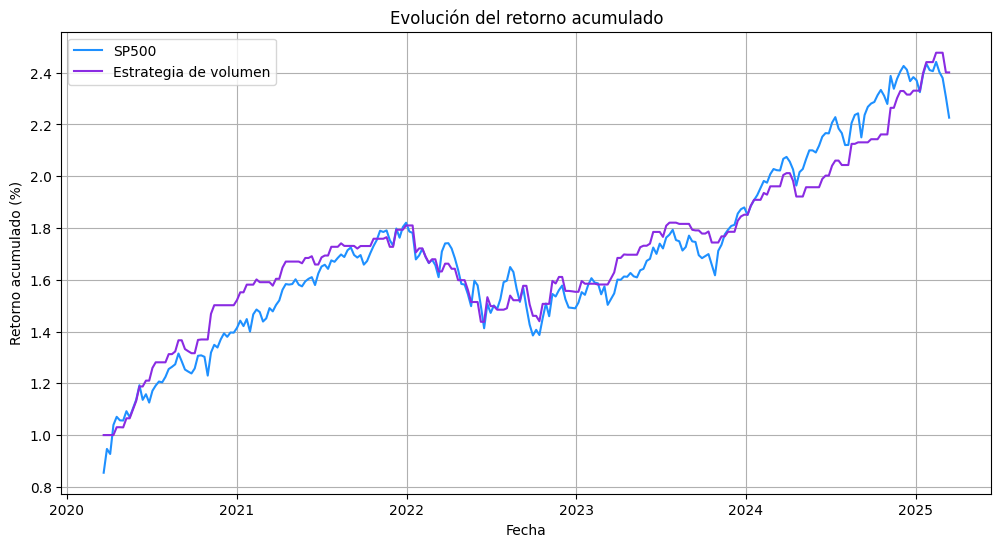

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(merged_data.index, merged_data['index_return_cum'], label='SP500', linestyle='-', color='dodgerblue')
plt.plot(merged_data.index, merged_data['portfolio_return_cum'], label='Estrategia de volumen', linestyle='-', color='blueviolet')
plt.xlabel('Fecha')
plt.ylabel('Retorno acumulado (%)')
plt.title('Evolución del retorno acumulado')
plt.legend()
plt.grid()
plt.show()

**Respuesta**: De las tres estrategias que hemos probado, esta es la que mejor ha funcionado. Existen periodos en los que la estrategia de volumen seguida para la palabra 'unemployment' sobrepasa el rendimiento del índice, especialmente entre principios de 2020 y finales de 2021, y desde finales de 2022 y finales de 2023.

Esto se puede deber a que en esos periodos había más incertidumbre y los mercados se regían por el miedo, por lo que los inversores prestaban más atención a indicadores adelantados como el desempleo para anticipar movimientos del mercado. El sentimiento económico reflejado en las búsquedas de 'unemployment' pudo haber sido un mejor predictor del rendimiento del índice porque los participantes del mercado reaccionaban con mayor sensibilidad a señales de deterioro o recuperación en el empleo.

Además, es posible que los cambios en política monetaria y fiscal en respuesta a la crisis de la COVID-19 y la guerra de Ucrania también hayan amplificado la relación entre la percepción del desempleo y el comportamiento del mercado.

##### Palabra: recession

In [82]:
# Cobertura de 'unemployment' de los últimos 5 años
f = Filters(
    keyword = "recession",
    country = "US",
    timespan = "60m",
)

gd = GdeltDoc()

# Realizar la consulta a la API de GDELT
timeline = gd.timeline_search("timelinevol", f)
timeline

,datetime,Volume Intensity
0,2020-04-08 00:00:00+00:00,0.5720
1,2020-04-09 00:00:00+00:00,0.9283
2,2020-04-10 00:00:00+00:00,0.8140
3,2020-04-11 00:00:00+00:00,0.3630
4,2020-04-12 00:00:00+00:00,0.3154
...,...,...
1793,2025-03-08 00:00:00+00:00,0.0770
1794,2025-03-09 00:00:00+00:00,0.1864
1795,2025-03-10 00:00:00+00:00,0.3352
1796,2025-03-11 00:00:00+00:00,0.6212


In [83]:
# Ponemos datetime como índice del dataframe
timeline.set_index('datetime', inplace=True)

# Convertimos el índice de 'timeline' a un formato sin zona horaria
timeline.index = timeline.index.tz_convert(None)

# Calculamos media móvil de 7 días y cambiar la frecuencia a semanal
timeline['rolling_avg'] = timeline['Volume Intensity'].rolling('7D').mean()

# Cambiamos la frecuencia semanal
timeline_weekly = timeline.resample('W-FRI').ffill()

# Unimos los datos del tono + datos de precios del SPY
merged_data = data[['Close']].merge(timeline_weekly['rolling_avg'], left_index=True, right_index=True, how='left')

# Rellenamos los missing values con el valor anterior
merged_data = merged_data.fillna(method='ffill')

# Añadir la columna 'buy' basada en la cobertura de noticias con la palabra 'economics'
merged_data['buy'] = merged_data['rolling_avg'].diff() < 0

# Calcular los retornos semanales del índice y la estrategia
merged_data['index_return'] = merged_data['Close'].pct_change()
merged_data['portfolio_return'] = merged_data['index_return'] * merged_data['buy'] # data['buy']=1 (True) | data['buy']=0 (False)

# Calcular el retorno acumulado
merged_data['index_return_cum'] = (1 + merged_data['index_return']).cumprod()
merged_data['portfolio_return_cum'] = (1 + merged_data['portfolio_return']).cumprod()


<ipython-input-83-d4a6d14dc0d3>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data = merged_data.fillna(method='ffill')


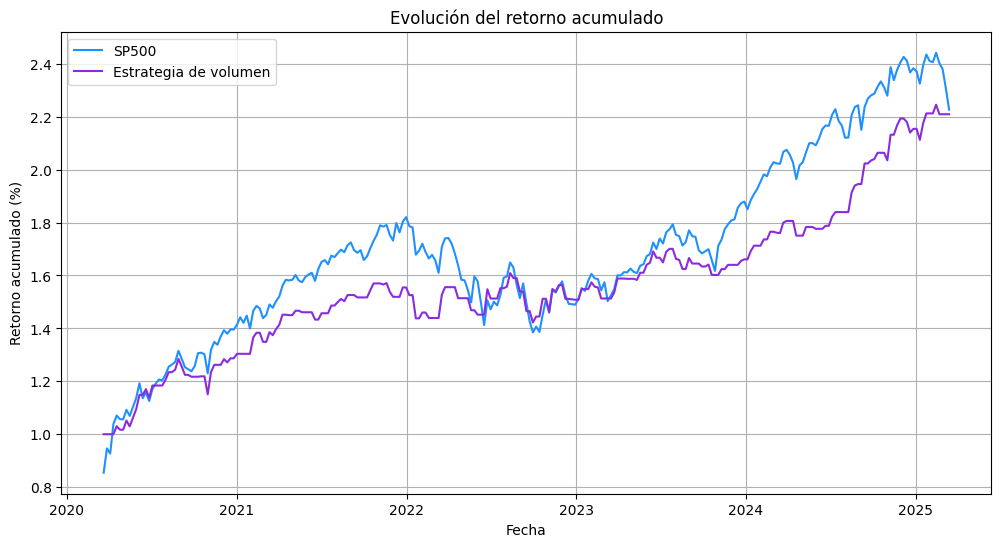

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(merged_data.index, merged_data['index_return_cum'], label='SP500', linestyle='-', color='dodgerblue')
plt.plot(merged_data.index, merged_data['portfolio_return_cum'], label='Estrategia de volumen', linestyle='-', color='blueviolet')
plt.xlabel('Fecha')
plt.ylabel('Retorno acumulado (%)')
plt.title('Evolución del retorno acumulado')
plt.legend()
plt.grid()
plt.show()

**Respuesta**: El S&P 500 (línea azul) muestra una trayectoria de crecimiento constante, aunque con fluctuaciones más pronunciadas. La estrategia de volumen de la palabra 'recession' (línea morada) sigue un patrón similar, pero con menor volatilidad y, previo a mediados de 2022 y tras inicios de 2023, con menor rendimiento acumulado.

Entre 2022 y 2023, ambas estrategias tienen un desempeño similar, aunque nuestra estrategia parece más estable. Durante 2024 y principios de 2025, el S&P 500 tiene un crecimiento más fuerte, aunque también con caídas más abruptas. Esta volatilidad se puede deber al inicio de la presidencia de Donald Trump. Al final del periodo, ambas estrategias convergen, probablemente debido a la tendencia bajista que ha marcado los primeros meses de 2025 y que ha afectado a las empresas del S&P 500.